# **Image denoising using Noise2Void 2D**

---

<font size = 4> Noise2Void 2D is deep-learning method that can be used to denoise 2D microscopy images. By running this notebook, you can train your own network and denoise your images. 
---

*Disclaimer*:

This notebook is part of the Zero-Cost Deep-Learning to Enhance Microscopy project (https://github.com/HenriquesLab/DeepLearning_Collab/wiki). Jointly developed by the Jacquemet (link to https://cellmig.org/) and Henriques (https://henriqueslab.github.io/) laboratories.

This notebook is largely based on the paper: **Noise2Void - Learning Denoising from Single Noisy Images**
Alexander Krull, Tim-Oliver Buchholz, Florian Jug
https://arxiv.org/abs/1811.10980

And source code found in: https://github.com/juglab/n2v



**Please also cite this original paper when using or developing this notebook.**


# **How to use this notebook?**
---

###**Table of contents, Code snippets** and **Files**

On the left side of the notebook you find three tabs which contain from top to bottom the table of contents, code snippets and files

*Table of contents* = contains structure of the notebook. Click the content to move quickly between sections.

*Code snippets* = contain examples how to code certain tasks. You can ignore this when using this notebook.

*Files* = contain all available files. After mounting your google drive (see section 1.) you will find your files and folders here. 

**Remember that all uploaded files are purged after changing the runtime.** All files saved in Google Drive will remain. You do not need to use the Mount Drive-button; your Google Drive is connected in section 1.2.

**Note:** The "sample data" in "Files" contains default files. Do not upload anything here!

---
###**Text** and **Code Cells**

**Text cells** provide information and can be modified by douple-clicking the cell. You are currently reading the text cell. You can create a new text by clicking `+ Text`.

**Code cells** contain code and the code can be modfied by selecting the cell. To execute the cell, move your cursor on the `[ ]`-mark on the left side of the cell (play button appear). Click to execute the cell. After execution is done the animation of play button stops. You can create a new coding cell by clicking `+ Code`.

---
###**Making changes to the notebook**

**Please make a copy** of the notebook and save it to your Google Drive if you make changes. To do this click file -> save a copy in drive.

To **edit a cell**, double click on the text. This will show you either the source code (in code cells) or the source text (in text cells).
It is advisable to use the `#`-mark in code cells. This allows you to keep the original code piece in the cell as a comment.

**For example:**

Original code: all lines are excuted

`my_files = 2`

`my_mask = "names of masks"`

Modified code: the 1st line is not executed, but the 2nd and 3rd line are.

`#my_files = 2`

`my_files = 200`

`my_mask = "names of masks"`

#**0. Before getting started**
---
<font size = 4>

1. Create the following folder tree in your Google Drive:

*   Data
    - test
    - train
      - training_image
      - trained_model
    - results

2. Place all your test images in the **test** folder
3. Place all your training images in the **training_image** folder.
4. The **Trained_model** folder will contain the parameter files and your trained network. If you have already trained a network, you can place it here.
5. The **Results** - folder will contain your denoised images. Your original images will remain unmodified in the test-folder.
---

**Use only .tif files!**


# **1. Set the Runtime type and mount your Google Drive**



### **1.1. Change the Runtime type**

Go to **Runtime -> Change the Runtime type**

**Runtime type: Python 3** *(Python 3 is programming language in which this program is written)*

**Accelator: GPU** *(Graphics processing unit (GPU)*


### **1.2. Mount your Google Drive**


In [0]:
#@markdown Play the cell to Mount your Google Drive.

#@markdown * Click on the URL. 

#@markdown * Sign in your Google Account. 

#@markdown * Copy the authorization code. 

#@markdown * Enter the authorization code. 

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive". 

# mount user's Google Drive to Google Colab.
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# **2. Install Noise2Void**

In [0]:
#@markdown ###Install Noise2Void and dependencies

# Here we enable Tensorflow 1. 
%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)
print("Tensorflow enabled.")


# Here we install Noise2Void
!pip install n2v

print("Noise2Void installed.")

# Here we install all libraries and other depencies to run the notebook.

from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile
from tifffile import imread
from csbdeep.io import save_tiff_imagej_compatible

from pathlib import Path
import os
import pandas as pd
import csv

!pip install memory_profiler
%load_ext memory_profiler
print("Libraries installed")


1.15.0
Tensorflow enabled.
     |████████████████████████████████| 61kB 3.0MB/s 
     |████████████████████████████████| 133kB 8.1MB/s 
     |████████████████████████████████| 18.1MB 195kB/s 
Noise2Void installed.


Using TensorFlow backend.


  Created wheel for memory-profiler: filename=memory_profiler-0.57.0-cp36-none-any.whl size=28992 sha256=99d29411536f23b2f78e4e0d81836dde7c1b754aefcb5b5083125406ef1c72cf
  Stored in directory: /root/.cache/pip/wheels/74/20/b5/20964ef97be73d2c3a695c9cad7bccd96d1e3e737a8163861f
Successfully built memory-profiler
Libraries installed


# **3. Select your parameters and paths**

---

**training:** Enter path of the folder containing your training image. This image will remain unmodified and N2V will only study it. Use only tif-files!

**prediction:** 
Enter a path for your images to-be predicted using the newly trained network.

**results:** 
Enter a path where you want to save your results.


**modelname** 
Use only my_model -style, not my-model. If you want to use a previously trained model, enter the name of the pretrained model (which should be contained in the trained_model -folder after training)

**modelpath**: 
Enter the path of the folder containing your new model or pretrained model.

<font size = 4>**If using a pretrained model, leave the rest of the below section blank. Parameters will be taken over from your model (see above)**

**steps:** 
The number of steps to train each epoch. Good network training may require at least 100 steps but will take a while.

**epochs:** 
Input how many epochs (rounds) network will be trained. A larger number of epochs may improve performance but risks overfitting to the training data. Start with 50-100 and test the performance after training (see 4.8.)

**number:**
Input the number of the patches per image. Increasing the number of patches allows for larger training datasets.

**size:**
divides the image into patches for training. Input the size of the patches (length of a side). The value should be smaller than the dimensions of the image and divisible to 4.
Default value is 96 x 96 pixels. Decreasing the patch size improves the training but increases also the training time.

In [0]:
# create DataGenerator-object.
datagen = N2V_DataGenerator()

#@markdown ###Path to training images: 
training = "/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/N2V 2D/Focal_adhesion_live/train" #@param {type:"string"}
training_images = training
imgs = datagen.load_imgs_from_directory(directory = training_images)

#@markdown ###Path to predicted images and results:
prediction = "/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/N2V 2D/Focal_adhesion_live/prediction" #@param {type:"string"}
test_data = prediction
results = "/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/N2V 2D/Focal_adhesion_live/results" #@param {type:"string"}


#@markdown ### Model name and path:
name = "N2V_adhesions_GJ" #@param {type:"string"}
my_model = name
modelpath = "/content/gdrive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/N2V 2D/Filopodia_widefield_dataset_low/results" #@param {type:"string"}
path_model = modelpath

#@markdown ### Other parameters for training:
#@markdown Number of steps and epochs:
steps = 100 #@param {type:"number"}
epochs =  200#@param {type:"number"}
#@markdown Patch size (pixels) and number
number =  400#@param {type:"number"}
size = 32 #@param {type:"number"}
width = size
height = 1
print("Parameters initated.")

# The shape of the images.
print("The shape of images:")
print(imgs[0].shape) #Not needed but if someonge  wish to see.

Parameters initated.
The shape of images:
(1, 512, 512, 1)


# **4. Train the network**

### **4.1. Inspecting training data**

<font size = 4>Here, we show the image that will be used for training the network.
---



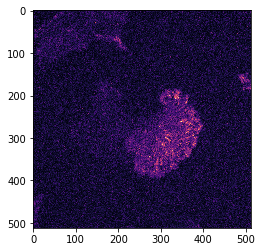

In [0]:
#@markdown ###Play the cell to show the image.

# creates a plot and shows the training image.
# The code is from the original notebook (https://github.com/juglab/n2v)
plt.imshow(imgs[0][0,...,0], cmap='magma')
plt.show()

### **4.2. Prepare the training data and model for training**
<font size = 4>Here, we use the information from 3. to build the model and convert the training data into a suitable format for training.

Generated patches: (1800, 32, 32, 1)
Generated patches: (1800, 32, 32, 1)
peak memory: 448.29 MiB, increment: 0.14 MiB













Setup done.


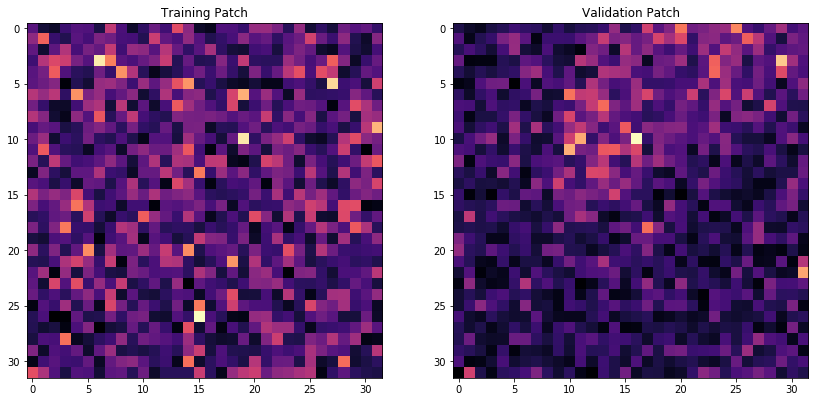

In [0]:
# The code is inspired from the original notebook (https://github.com/juglab/n2v)

#@markdown ###Create the model and dataset objects


# split patches from the training images
Xdata = datagen.generate_patches_from_list(imgs, shape=(size,size))
shape_of_Xdata = Xdata.shape
# create a threshold (10 % patches for the validation)
threshold = int(shape_of_Xdata[0]/10)
# split the patches into training patches and validation patches
X = Xdata[threshold:]
X_val = Xdata[:threshold]
%memit 


# create a Config object
config = N2VConfig(X, unet_kern_size=3, 
                   train_steps_per_epoch=steps,train_epochs=epochs, train_loss='mse', batch_norm=True, 
                   train_batch_size=number, n2v_perc_pix=1.6, n2v_patch_shape=(size, size), 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5)

# Let's look at the parameters stored in the config-object.
vars(config)

# a name the model
model_name = my_model                                  
# the base directory for your model
basedir = path_model             
# create network model.
model = N2V(config, model_name, basedir=basedir)

print("Setup done.")


# creates a plot and shows one training patch and one validation patch.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,...,0], cmap='magma')
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,...,0], cmap='magma')
plt.title('Validation Patch');

### **4.3. Train the network**
<font size = 4>When playing the cell below you should see updates after each epoch (round). Network training can take some time. You can estimate the training time by following equation: 

<font size = 4>t(training) = ( t(s)/epoch *x* epochs)/60. 

<font size = 4>**For example:**

<font size = 4>**t(training) = (16 s/epoch x 400 epochs)/60 = 106,7 min**

<font size = 4>* **CRITICAL NOTE:** Google Colab has time limit for processing (to prevent using GPU power for datamining). Training time must be less than 12 hours! If training takes longer than 12 hours, please decrease the training parameters or training data.

In [0]:
#@markdown ###Start Training
%memit
# The code is from the original notebook (https://github.com/juglab/n2v)
# Play the cell to start training the network.
history = model.train(X, X_val)
print("Training done.")
%memit

peak memory: 988.96 MiB, increment: 0.04 MiB



Preparing validation data:   0%|          | 0/360 [00:00<?, ?it/s]

16 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 360/360 [00:00<00:00, 944.48it/s]




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




Epoch 1/15
10/10 [==============================] - 13s 1s/step - loss: 1.6206 - n2v_mse: 1.6206 - n2v_abs: 0.9348 - val_loss: 1.3446 - val_n2v_mse: 1.3446 - val_n2v_abs: 0.7529

Epoch 2/15
10/10 [==============================] - 3s 273ms/step - loss: 0.8958 - n2v_mse: 0.8958 - n2v_abs: 0.6960 - val_loss: 0.9748 - val_n2v_mse: 0.9748 - val_n2v_abs: 0.6706
Epoch 3/15
10/10 [==============================] - 4s 407ms/step - loss: 0.6908 - n2v_mse: 0.6908 - n2v_abs: 0.6100 - val_loss: 0.6782 - val_n2v_mse: 0.6782 - val_n2v_abs: 0.6063
Epoch 4/15
10/10 [==============================] - 4s 423ms/step - loss: 0.6084 - n2v_mse: 

### **4.4. Evaluate the training**


# Here we look at the resulting image


100%|██████████| 2/2 [00:00<00:00, 43.12it/s]


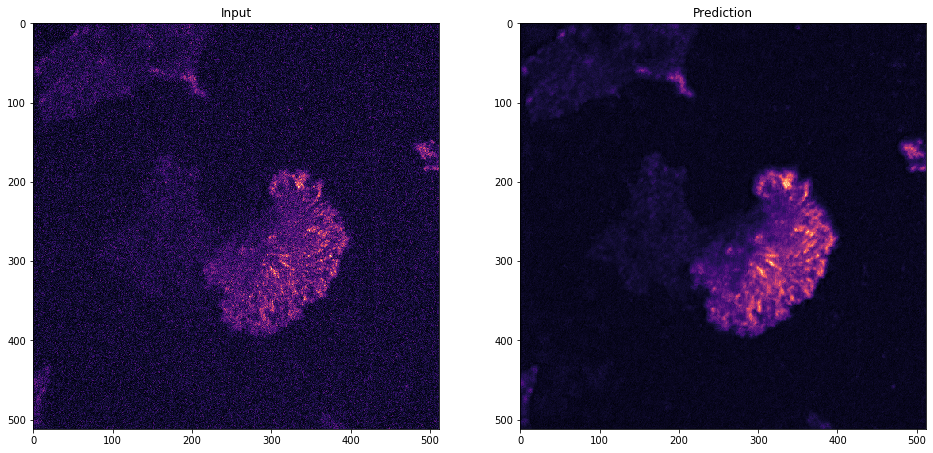

In [0]:
#@markdown ###Play the cell to look at your image after denoising
# We load the data we want to process.
input_train = imgs[0][0,...,0]
# Here we process the data.
# The parameter 'n_tiles' can be used if images are to big for the GPU memory.
# If we do not provide the n_tiles' parameter the system will automatically try to find an appropriate tiling.
# This can take longer.
pred_train = model.predict(input_train, axes='YX', n_tiles=(2,1))

# Let's look at the results.
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(input_train[:1500:,:1500],cmap="magma")
plt.title('Input');
plt.subplot(1,2,2)
plt.imshow(pred_train[:1500,:1500],cmap="magma")
plt.title('Prediction');


<font size = 4>It is good practice to evaluate the training progress by comparing the training loss with the validation loss. The latter is a metric which shows how well the network performs on a subset of unseen data which is set aside from the training dataset. For more information on this, see for example [this review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6381354/) by Nichols *et al.*

<font size = 4>**Loss** <code>(loss)</code> describes an error value after each epoch for the difference between the model's prediction and its 'GT' target.

<font size = 4>**Validation error** <code>(val_loss)</code> describes the same error value between the model's prediction on a validation image (taken from 'low') and compared to it's target (from 'GT').

<font size = 4>During training both values should decrease before reaching a minimal value which does not decrease even after further training. Comparing the development of the validation error with the training error can give insights into the model's performance.

<font size = 4>If **validation error is clearly higher than training error**, it means that the training data might be too complex or diverse. In this case, the trained network fails to improve unseen images. To avoid this, increase the number of epochs and check if you can improve your dataset with more examples.

<font size = 4>If **validation error is clearly smaller than training error**, it means that training data is too simple which allows the network to learn the training data perfectly but to perform poorly on unseen data. This is called overfitting which should be always be avoided as it can lead to artefacts in the predctions of the network. First steps to avoid this can be to reduce the number of training epochs or to use a larger training dataset.

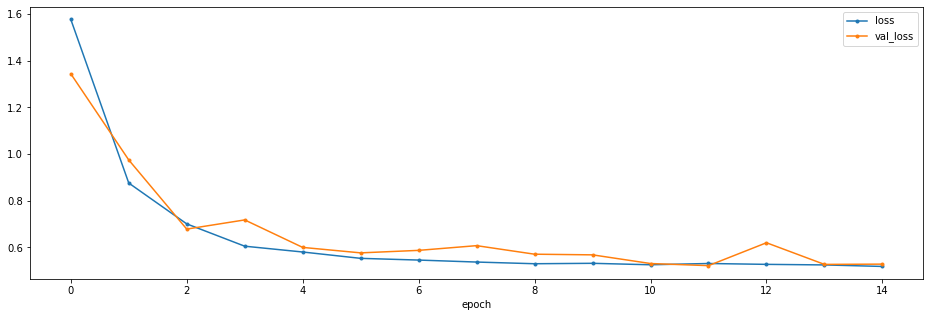

In [0]:
#@markdown ###Play the cell to show a figure of the training errors

#@title Play the cell to show figure of training results
# The code is from the original notebook (https://github.com/juglab/n2v)
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# The figure is saved into content/ as test.csv (refresh the Files if needed). 
RESULTS = results+'/test.csv'
with open(RESULTS, 'w') as f:
    for key in hist_df.keys():
        f.write("%s,%s\n"%(key,hist_df[key]))

### **4.5. Export model to be used with *CSBDeep Fiji plugins* and *KNIME* workflows**

<font size = 4>This allows you to save the trained model in a format where it can be used in the CSBDeep Fiji Plugin. See https://github.com/CSBDeep/CSBDeep_website/wiki/Your-Model-in-Fiji for details.

<font size = 4>After saving the model to your drive, download the .zip file from your google drive. Do this from your Google Drive and not in the colab interface as this takes very long.

In [0]:
#@markdown ###Play this cell to save a Fiji compatible model to Google Drive.

# exports the trained model to Fiji.
# The code is from (https://github.com/CSBDeep/CSBDeep).
model.export_TF()



Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /tmp/tmp4aaeptcx/model/saved_model.pb

Model exported in TensorFlow's SavedModel format:
/content/gdrive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/N2V 2D/Filopodia_widefield_dataset_low/results/N2V_adhesions_GJ/TF_SavedModel.zip


# **5. Prediction**

---

<font size = 4>In this section the unseen data is predicted using the trained model (in section 4). First we upload your unseen images and prepare them for prediction. After that we activate your trained model from section 4 and finally we save results into your Google Drive.

### **5.1. Using the trained model for predictions**

<font size = 4>The trained model (from section 4.6) can now be used for images for which no ground-truth yet exists. Images are saved your results folder as restored image stacks ( ImageJ-compatible TIFF images).

In [0]:
#@markdown Play the cell to activate a pretrained model.

#@markdown ### If you have trained network in section 4, DO NOT run this cell. Doing so will crash the notebook.

# The code is from the original notebook (https://github.com/juglab/n2v)
# a name the model
model_name = my_model                                  
# the base directory for your model
basedir = path_model             
# create network model as pretrained model.
config = None
model = N2V(config, model_name, basedir=basedir)

print("Setup done.")

Loading network weights from 'weights_best.h5'.
Setup done.


### 5.2. Prediction of images

In [0]:
#@markdown ### Play the cell to predict your unseen images

print("Saving the images...")
thisdir = Path(test_data)
outputdir = Path(results)

# r=root, d=directories, f = files
for r, d, f in os.walk(thisdir):
    for file in f:
        if ".tif" in file:
            print(os.path.join(r, file))

# The code by Lucas von Chamier.
for r, d, f in os.walk(thisdir):
  for file in f:
    base_filename = os.path.basename(file)
    input_train = imread(os.path.join(r, file))
    pred_train = model.predict(input_train, axes='YX', n_tiles=(2,1))
    save_tiff_imagej_compatible(os.path.join(outputdir, base_filename), pred_train, axes='YX')         
print("Completed.")

Saving the images...
/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/N2V 2D/Focal_adhesion_live/prediction/FA - 3488 Evolve.tiff
/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/N2V 2D/Focal_adhesion_live/prediction/FA - 9488 Evolve.tiff
/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/N2V 2D/Focal_adhesion_live/prediction/FA - 4488 Evolve.tiff
/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/N2V 2D/Focal_adhesion_live/prediction/FA - 8488 Evolve.tiff
/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/N2V 2D/Focal_adhesion_live/prediction/FA - 1488 Evolve.tiff
/content/gdrive/My Drive/Work/manuscript/Ong

100%|██████████| 2/2 [00:00<00:00, 36.31it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 31.91it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 35.97it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 32.64it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 36.30it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 32.59it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 34.64it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 34.28it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 33.25it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 33.88it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 32.98it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 34.45it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 33.55it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 33.23it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 35.76it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 31.56it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 34.21it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 34.37it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 34.75it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 31.02it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 35.88it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 33.90it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 33.01it/s]

The input image is of type uint16 and will be casted to float32 for prediction.
Completed.


# **6. Store your results**

---
<font size = 4>**Store your data** and ALL its results elsewhere and after that clean the original folder tree (datasets, results, trained model etc.) if you plan to train or use new networks. Please note that notebook will **OVERWRITE** all files which have the same name.